<a href="https://colab.research.google.com/github/GodaBac/BachelorThesis/blob/main/Fourier/FourierSeries_%2B_SARIMAX_for_standardized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
from datetime import datetime

input_file_path = '/content/drive/MyDrive/Bakalauras/duomenys.csv'

# Open the input CSV file
with open(input_file_path, 'r') as input_file:
    reader = csv.reader(input_file)

    value_names = next(reader)

    # Create an empty list to store the updated rows
    updated_rows = []

    # Loop through each row in the input file
    for row in reader:
         # Try to parse the date string as a datetime object
        try:
            date_str = row[0]
            date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        except ValueError:
            # If the date string is not in the expected format, skip this row
            continue

        # Format the date object as a string in the new format
        new_date_str = date_obj.strftime('%Y-%m-%d')

        # Update the date value in the row
        row[0] = new_date_str
        # Append the updated row to the list of updated rows
        updated_rows.append(row)

# Convert the list of updated rows to a dataframe
df = pd.DataFrame(updated_rows, columns=value_names)

In [ ]:
# Convert the date column to a datetime object
df['DT'] = pd.to_datetime(df['DT'], format='%Y-%m-%d')

# Set the date column as the index of the dataframe
df.set_index('DT', inplace=True)
df['ANTAL_01'] = df['ANTAL_01'].astype(int)
df = df.iloc[::-1]

In [ ]:
from sklearn.preprocessing import StandardScaler
from math import sqrt
# prepare data for standardization
values = df.values
print(values)
values = values.reshape((len(values), 1))
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
 print(normalized[i])
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
 print(inversed[i])
df['ANTAL_01'] = normalized
print(df)

[[46084]
 [46026]
 [46108]
 ...
 [30152]
 [30121]
 [30090]]
Mean: 40906.524202, StandardDeviation: 4750.513865
[1.089877]
[1.07766779]
[1.09492908]
[1.07114218]
[1.06251154]
[46084.]
[46026.]
[46108.]
[45995.]
[45954.]
            ANTAL_01
DT                  
2015-12-31  1.089877
2016-01-04  1.077668
2016-01-05  1.094929
2016-01-06  1.071142
2016-01-07  1.062512
...              ...
2022-12-15 -2.236921
2022-12-16 -2.251025
2022-12-19 -2.263865
2022-12-20 -2.270391
2022-12-21 -2.276917

[1818 rows x 1 columns]


In [ ]:
#training and test
training = df.iloc[:-16,:]
print(training.index)
testing = df.iloc[-16:, :]
training.head()

DatetimeIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14',
               ...
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25',
               '2022-11-28', '2022-11-29'],
              dtype='datetime64[ns]', name='DT', length=1802, freq=None)


,ANTAL_01
DT,
2015-12-31,1.089877
2016-01-04,1.077668
2016-01-05,1.094929
2016-01-06,1.071142
2016-01-07,1.062512


In [ ]:
# Define number of Fourier terms to use
n_terms = 22

# Define the time period of the data (in this example, one year)
period = 262

In [ ]:
# Create Fourier series terms
t = np.arange(len(training))
fourier_terms = []
for i in range(1, n_terms+1):
    fourier_terms += [np.sin(2*np.pi*i*t/period), np.cos(2*np.pi*i*t/period)]

In [ ]:
# Add Fourier series terms to data frame
fourier_df = pd.DataFrame(np.array(fourier_terms).T, index=training.index, columns=[f'fourier_{i+1}' for i in range(2*n_terms)])
training = pd.concat([training, fourier_df], axis=1)

In [ ]:
# Specify exogenous variables for SARIMAX model
exog_vars = ['fourier_{}'.format(i+1) for i in range(n_terms)]

In [ ]:
# Train SARIMAX model with exogenous variables
model = sm.tsa.statespace.SARIMAX(training['ANTAL_01'], exog=training[exog_vars], order=(1,1,1), seasonal_order=(1,0,1,22))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

In [ ]:
exogTest = training.tail(22)
exogTest2 = exogTest.head(len(testing))
exogTest2
exogvar = np.asarray(exogTest2[exog_vars])
exogvar = np.asarray(exogTest2[exog_vars])
exogvar
test_exog = pd.DataFrame(exogvar, index=testing.index)
test_exog

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
DT,,,,,,,,,,,,,,,,,,,,,
2022-11-30,-0.962211,0.272306,-0.524031,-0.851699,0.676817,-0.736151,0.892634,0.450782,-0.190678,0.981653,...,-0.352016,-0.935994,0.804767,-0.593590,0.790302,0.612718,-0.374360,0.927284,-0.994183,-0.107708
2022-12-01,-0.955404,0.295301,-0.564263,-0.825595,0.622150,-0.782898,0.931706,0.363214,-0.071883,0.997413,...,-0.503457,-0.864020,0.676817,-0.736151,0.903187,0.429248,-0.143394,0.989666,-0.987875,0.155250
2022-12-02,-0.948049,0.318126,-0.603197,-0.797592,0.564263,-0.825595,0.962211,0.272306,0.047945,0.998850,...,-0.640744,-0.767755,0.524031,-0.851699,0.974160,0.225860,0.095779,0.995403,-0.913220,0.407467
2022-12-05,-0.940147,0.340768,-0.640744,-0.767755,0.503457,-0.864020,0.983868,0.178894,0.167084,0.985943,...,-0.760016,-0.649904,0.352016,-0.935994,0.999928,0.011991,0.329471,0.944166,-0.775382,0.631492
2022-12-06,-0.931706,0.363214,-0.676817,-0.736151,0.440047,-0.897975,0.996479,0.083837,0.283824,0.958876,...,-0.857921,-0.513781,0.167084,-0.985943,0.979296,-0.202435,0.544304,0.838888,-0.583898,0.811827
2022-12-07,-0.922728,0.385451,-0.711333,-0.702855,0.374360,-0.927284,0.999928,-0.011991,0.396488,0.918040,...,-0.931706,-0.363214,-0.023979,-0.999712,0.913220,-0.407467,0.727983,0.685595,-0.352016,0.935994
2022-12-08,-0.913220,0.407467,-0.744214,-0.667942,0.306735,-0.951795,0.994183,-0.107708,0.503457,0.864020,...,-0.979296,-0.202435,-0.214163,-0.976798,0.804767,-0.593590,0.869995,0.493061,-0.095779,0.995403
2022-12-09,-0.903187,0.429248,-0.775382,-0.631492,0.237524,-0.971382,0.979296,-0.202435,0.603197,0.797592,...,-0.999353,-0.035965,-0.396488,-0.918040,0.658970,-0.752169,0.962211,0.272306,0.167084,0.985943
2022-12-12,-0.892634,0.450782,-0.804767,-0.593590,0.167084,-0.985943,0.955404,-0.295301,0.694275,0.719710,...,-0.991314,0.131517,-0.564263,-0.825595,0.482594,-0.875844,0.999353,0.035965,0.418387,0.908269


In [ ]:
# predict using SARIMAX model
pred = results.predict(start=len(training), end=len(training)+len(testing)-1, exog=test_exog)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
pred, testing['ANTAL_01']

(1802   -1.928011
 1803   -1.868961
 1804   -1.890049
 1805   -1.960029
 1806   -2.005283
 1807   -2.019097
 1808   -2.022150
 1809   -2.035805
 1810   -2.040895
 1811   -2.047599
 1812   -2.066523
 1813   -2.066761
 1814   -2.079597
 1815   -2.086933
 1816   -2.092482
 1817   -2.103729
 Name: predicted_mean, dtype: float64,
 DT
 2022-11-30   -1.831281
 2022-12-01   -1.764551
 2022-12-02   -1.786864
 2022-12-05   -2.105988
 2022-12-06   -2.139458
 2022-12-07   -2.171665
 2022-12-08   -2.200083
 2022-12-09   -2.202398
 2022-12-12   -2.224501
 2022-12-13   -2.237553
 2022-12-14   -2.258182
 2022-12-15   -2.236921
 2022-12-16   -2.251025
 2022-12-19   -2.263865
 2022-12-20   -2.270391
 2022-12-21   -2.276917
 Name: ANTAL_01, dtype: float64)

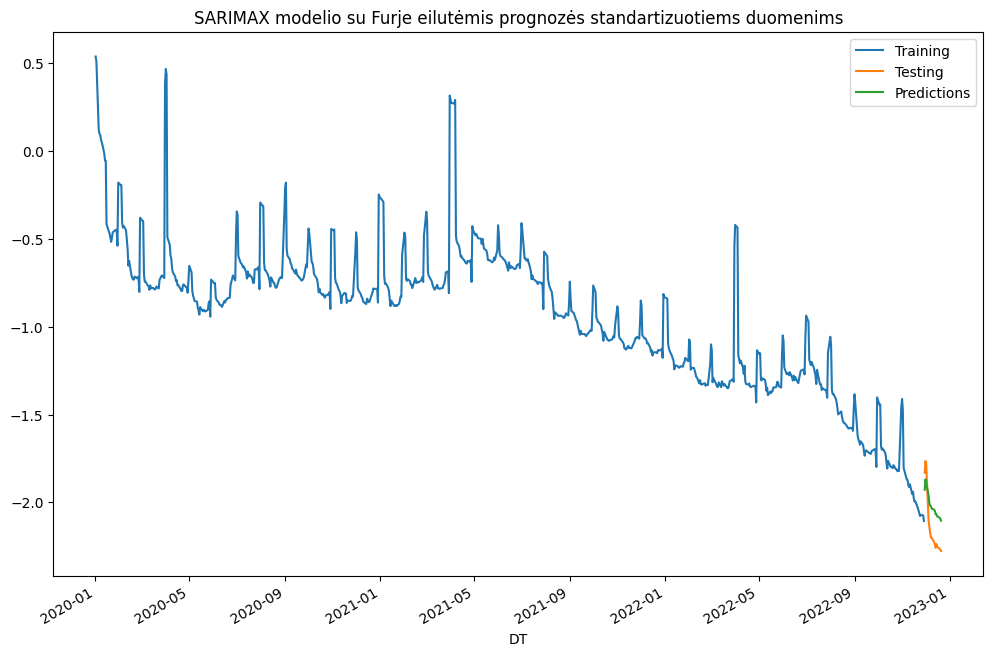

In [ ]:
import matplotlib.pyplot as plt
training['ANTAL_01'].astype(float)['2020-01-01':].plot(figsize=(12, 8), label='Training')
testing['ANTAL_01'].astype(float).plot(label='Testing')
pred.index = testing.index
pred.plot(label='Predictions')
plt.title('SARIMAX modelio su Furje eilutėmis prognozės standartizuotiems duomenims')
plt.legend()

In [ ]:
predictions = pred
# inverse transform and print the first 5 rows
normalized_predictions = predictions.values.reshape((len(predictions.values), 1))
print(normalized_predictions)
inversed = scaler.inverse_transform(normalized_predictions)
print(inversed)

[[-1.92801067]
 [-1.86896094]
 [-1.89004903]
 [-1.96002925]
 [-2.00528295]
 [-2.0190969 ]
 [-2.02214998]
 [-2.03580481]
 [-2.04089466]
 [-2.04759888]
 [-2.06652283]
 [-2.06676059]
 [-2.07959731]
 [-2.08693302]
 [-2.09248185]
 [-2.10372901]]
[[31747.48279857]
 [32027.99933863]
 [31927.8200931 ]
 [31595.3780614 ]
 [31380.39972689]
 [31314.77640313]
 [31300.27268264]
 [31235.40524414]
 [31211.22580992]
 [31179.37731681]
 [31089.47885934]
 [31088.34938334]
 [31027.36832721]
 [30992.51995245]
 [30966.1601656 ]
 [30912.73037063]]
